In [1]:
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt
from matplotlib import rc
%matplotlib inline
from astropy.visualization import hist
from ccdproc import ImageFileCollection
import ccdproc as ccdp
from astropy.modeling import fitting
from astropy.modeling.models import Polynomial1D,Chebyshev1D,Legendre1D,Hermite1D
from astropy.nddata import CCDData
import glob
from datetime import datetime
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.colors as colors
from matplotlib.cm import get_cmap
import colorcet as cc
import cmasher as cmr
from astropy import units as u
import shutil

In [2]:
phot_tutorial_dir = '/Users/sofimar/Software/py/ccd-reduction-and-photometry-guide/notebooks/'
import sys
sys.path.insert(0,phot_tutorial_dir)
from convenience_functions import show_image

In [3]:
data_dir = '/Users/sofimar/Desktop/Observational Astro/Imaging/'
reduced_dir = '/Users/sofimar/Desktop/Observational Astro/Reduced/'

In [4]:
def data_opener(a,b,fpath_list,hdu_list,hdr_list, d=3):
    for i in range(b-a):
        c = i+a+1
        if d==3:
            fpath = data_dir+'/a'+str(c)+'.fits'
            file_ = fits.open(fpath)
        if d==2:
            fpath = data_dir+'/a0'+str(c)+'.fits'
            file_ = fits.open(fpath)
        if d==1:
            fpath = data_dir+'/a00'+str(c)+'.fits'
            file_ = fits.open(fpath)
        fpath_list.append(fpath)
        hdu_list.append(file_)
        hdr_list.append(file_[0].header)
        
    return fpath_list, hdu_list, hdr_list

In [5]:
def file_list(a,b,lst, d=3):
    for i in range(b-a):
        c = i+a+1
        if d==3:
            fpath = data_dir+'/a'+str(c)+'.fits'
        if d==2:
            fpath = data_dir+'/a0'+str(c)+'.fits'
        if d==1:
            fpath = data_dir+'/a00'+str(c)+'.fits'
        lst.append(fpath)
    return lst


In [6]:
img_names = []
bias = []

In [7]:
# Science Frames
file_list(80,92,img_names, d=2)
file_list(129,139,img_names, d=3)
file_list(152,163,img_names, d=3)
file_list(201,211,img_names, d=3)
file_list(236,246,img_names, d=3)

# Bias Frames
file_list(92,99,bias, d=2)
file_list(99,111, bias)

# Flat Frames
file_list(4,9, img_names, d=1)
file_list(9,20, img_names, d=2)
file_list(21,28, img_names, d=2)
file_list(31,55, img_names, d=2)
file_list(56,62, img_names, d=2)

['/Users/sofimar/Desktop/Observational Astro/Imaging//a081.fits',
 '/Users/sofimar/Desktop/Observational Astro/Imaging//a082.fits',
 '/Users/sofimar/Desktop/Observational Astro/Imaging//a083.fits',
 '/Users/sofimar/Desktop/Observational Astro/Imaging//a084.fits',
 '/Users/sofimar/Desktop/Observational Astro/Imaging//a085.fits',
 '/Users/sofimar/Desktop/Observational Astro/Imaging//a086.fits',
 '/Users/sofimar/Desktop/Observational Astro/Imaging//a087.fits',
 '/Users/sofimar/Desktop/Observational Astro/Imaging//a088.fits',
 '/Users/sofimar/Desktop/Observational Astro/Imaging//a089.fits',
 '/Users/sofimar/Desktop/Observational Astro/Imaging//a090.fits',
 '/Users/sofimar/Desktop/Observational Astro/Imaging//a091.fits',
 '/Users/sofimar/Desktop/Observational Astro/Imaging//a092.fits',
 '/Users/sofimar/Desktop/Observational Astro/Imaging//a130.fits',
 '/Users/sofimar/Desktop/Observational Astro/Imaging//a131.fits',
 '/Users/sofimar/Desktop/Observational Astro/Imaging//a132.fits',
 '/Users/s

#### Load Darks

In [8]:
drk_num = ['001','002','003','004','005','006','007','008','009','010','011','012','013','014','015']

for i in range(len(drk_num)):
    dpath = data_dir+'/d'+drk_num[i]+'.fits'
    img_names.append(dpath)

In [9]:
np.shape(img_names)

(121,)

# HW 4R

- 3rd order polynomial

In [4]:
good_chunk = '[54:2101,:]'
bad_chunk = '[2102:,:]'

poly3 = Polynomial1D(3)

## Subtract Overscan, Trim, and Combine Bias Frames

### Subtract Overscan and Trim

In [12]:
bframes = ImageFileCollection(filenames=bias)
for b_ccd, filename_b in bframes.ccds(ccd_kwargs={'unit':'adu'}, return_fname=True):
    b_ccd = ccdp.subtract_overscan(b_ccd, fits_section=bad_chunk, model=poly3)
    b_ccd = ccdp.trim_image(b_ccd, fits_section=good_chunk)
    newbias = filename_b.strip('.fits')+'ot.fits'
    b_ccd.write(reduced_dir+'Bias/'+newbias, overwrite=True)
    

### Make Master Bias

In [5]:
from astropy.stats import mad_std

In [6]:
bias_dir = reduced_dir+'Bias/'

In [31]:
bias_ot = ImageFileCollection(location=bias_dir, glob_exclude=None)
master_bias = ccdp.combine(bias_ot.ccds(ccd_kwargs={'unit':'adu'}), method='average', sigma_clip=True, sigma_clip_func=np.ma.median,
sigma_clip_dev_func=mad_std, mem_limit=350E+6, unit=u.adu)

master_bias.meta['combined'] = True
master_bias.write(bias_dir+'master_bias.fits', overwrite=True)

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader inste

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:splitting each image into 11 chunks to limit memory usage to 350000000.0 bytes.


INFO: splitting each image into 11 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


## Subtract Overscan, Trim, and Subtract Bias from Science, Flat, and Dark Frames

In [33]:
sfd_frames = ImageFileCollection(filenames=img_names)
for sfd_ccd, filename_sfd in sfd_frames.ccds(ccd_kwargs={'unit':'adu'}, return_fname=True):
    sfd_ccd = ccdp.subtract_overscan(sfd_ccd, fits_section=bad_chunk, model=poly3)
    sfd_ccd = ccdp.trim_image(sfd_ccd, fits_section=good_chunk)
    sfd_ccd = ccdp.subtract_bias(sfd_ccd, master_bias)
    newframe = filename_sfd.strip('.fits')+'otz.fits'
    sfd_ccd.write(reduced_dir+newframe, overwrite=True)

## Subtract Bias from Bias

In [106]:
b_img = ImageFileCollection(location=bias_dir, glob_exclude='master_bias.fits')

In [112]:
master_bias = fits.open(bias_dir+'master_bias.fits')
master_bias = CCDData(master_bias[0].data, unit=u.adu)
for b_ccd, b_file in b_img.ccds(ccd_kwargs={'unit':'adu'}, return_fname=True):
    b_ccd = ccdp.subtract_bias(b_ccd, master_bias)
    b_name = b_file.strip('.fits')+'z.fits'
    b_ccd.write(bias_dir+b_name, overwrite=True)

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


# Hw 5

## Step 1

V-band Flats: 43-49

In [7]:
vflats = []
vflat_vals = []
vflat_hdr = []
for i in range(7):
    fpath = reduced_dir+'a0'+str(i+43)+'otz.fits'
    file_ = fits.open(fpath)
    vflats.append(file_)
    vflat_vals.append(file_[0].data)
    vflat_hdr.append(file_[0].header)

In [8]:
vflat_avg = np.mean(vflat_vals)
print(vflat_avg)

23932.247063907045


/var/folders/41/bw8lksgn1qnf46x_jj7ryc4r0000gn/T/ipykernel_8940/2386498536.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.0)


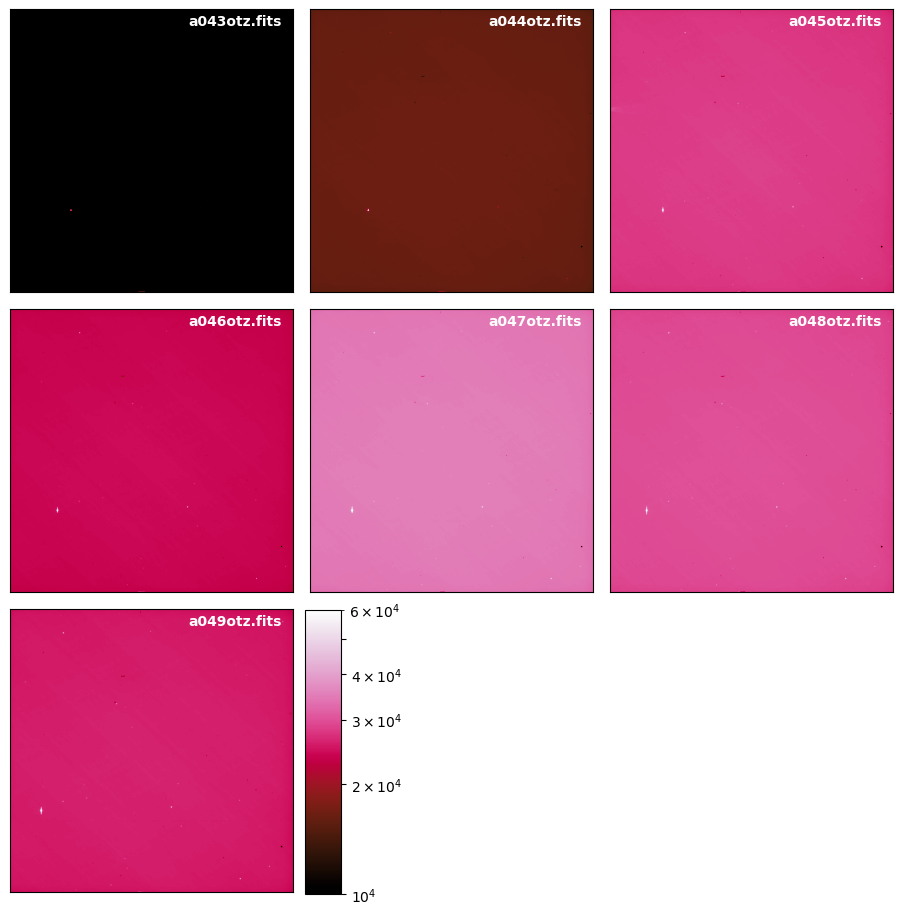

In [10]:
fig = plt.figure(figsize=(9,9))

p1 = fig.add_subplot(3,3,1)
f1 = plt.imshow(vflat_vals[0], cmap=cmr.flamingo, norm=colors.LogNorm(), origin='lower')
plt.yticks(ticks=[])
plt.xticks(ticks=[])
# cb = fig.colorbar(f1, pad=0.05)
plt.clim(10**4, 6*10**4)
plt.text(1290, 1930, 'a043otz.fits', color='white', weight='bold')

p2 = fig.add_subplot(3,3,2)
plt.yticks(ticks=[])
plt.xticks(ticks=[])
f2 = plt.imshow(vflat_vals[1],  cmap=cmr.flamingo,  norm=colors.LogNorm(), origin='lower')
# cb2 = fig.colorbar(f2, pad=0.05)
plt.clim(10**4, 6*10**4)
plt.text(1290, 1930, 'a044otz.fits', color='white', weight='bold')


p3 = fig.add_subplot(3,3,3)
f3 = plt.imshow(vflat_vals[2],  cmap=cmr.flamingo, norm=colors.LogNorm(), origin='lower')
plt.clim(10**4, 6*10**4)
plt.yticks(ticks=[])
plt.xticks(ticks=[])
plt.text(1290, 1930, 'a045otz.fits', color='white', weight='bold')
# cb3 = fig.colorbar(f3, pad=0.05)

p4 = fig.add_subplot(3,3,4)
f4 = plt.imshow(vflat_vals[3],  cmap=cmr.flamingo, norm=colors.LogNorm(), origin='lower')
plt.yticks(ticks=[])
plt.xticks(ticks=[])
# cb4 = fig.colorbar(f4, pad=0.05)
plt.clim(10**4, 6*10**4)
plt.text(1290, 1930, 'a046otz.fits', color='white', weight='bold')

p5 = fig.add_subplot(3,3,5)
f5 = plt.imshow(vflat_vals[4], cmap=cmr.flamingo, norm=colors.LogNorm(), origin='lower')
plt.yticks(ticks=[])
plt.xticks(ticks=[])
# cb5 = fig.colorbar(f5, pad=0.05)
plt.clim(10**4, 6*10**4)
plt.text(1290, 1930, 'a047otz.fits', color='white', weight='bold')

p6 = fig.add_subplot(3,3,6)
f6 = plt.imshow(vflat_vals[5],  cmap=cmr.flamingo, norm=colors.LogNorm(), origin='lower')
plt.yticks(ticks=[])
plt.xticks(ticks=[])
plt.clim(10**4, 6*10**4)
plt.text(1290, 1930, 'a048otz.fits', color='white', weight='bold')
# cb6 = fig.colorbar(f6, pad=0.05)

p7 = fig.add_subplot(3,3,7)
f7 = plt.imshow(vflat_vals[6], cmap=cmr.flamingo,  norm=colors.LogNorm(), origin='lower')
plt.yticks(ticks=[])
plt.xticks(ticks=[])
plt.clim(10**4, 6*10**4)
plt.text(1290, 1930, 'a049otz.fits', color='white', weight='bold')

cb_ax = fig.add_axes([.328,0.007,.04,.316])
cb = fig.colorbar(f7,  cax=cb_ax)
cb.set_ticks(ticks=[10**4,2*10**4,3*10**4,4*10**4,5*10**4])

plt.tight_layout(pad=0.0)

The reduced flats have a few saturated pixels and pixel 'clumps' and a few undersaturated pixels. The most noticeable saturated spot one is the one in the upper left of each frame and the easiest undersaturated pixel to observe is the black dot in the top right of each image. 


The background values of these flat frames differ from one another, though frames a045, a046, a048, and a049 have similar background pixel values. a043 and a044 are significantly dimmer and a047 is noticeably brighter than the rest of the frames. Therefore, in order to combine them appropriately, we must rescale them so that all frames have similar values. We can do this by rescaling each individual frame so that their pixel values are represented as a fraction of their mean and then combine the rescaled images using the mean or median of all the images.

## Advantages and Disadvantages of Different Combining Methods


### Average of All Frames
**Advantages**
- Master Flat pixel values will be a good estimate of the values of all the flats


**Disadvantages**
- Outliers (oversaturated and undersaturated pixels) will skew the mean, so it may not give you the most accurate estimate of all the flats

**Solution:** We can sigma clip to get rid of outliers!


### Median of All Frames
**Advantages**
- Not affected (or at least not significantly affected) by outliers


**Disadvantages**
- Since the values of the rescaled flats will be very similar to one another, the median may not be as good of an estimate as the average since it could give you a mode rather than an estimate or slightly skew the result. For instance, if the values of one pixel for a set of 5 flat frames are [0.4, 0.4, 0.4, 0.6, 0.6], the median is 0.4, which doesn't really account for the fact that the pixel value could be a little higher. The mean on the other hand, is 0.48. Although the median is still a pretty good estimate since all the values are so close to each other, the mean (in this case) would give a better estimate.


### Weighted mean & Sigma Clipping

**Advantages**
- Gets rid of outliers
- Frames with higher values get weighted more

**Disadvantages**
- I completely misread the bullet point and thought it was just good ol' 'mean & sigma clipping method' and didn't realize what you actually meant until I had already finished everything and went back to clean up the notebook
- Will make you sad

### Rescaling to the same level

In [11]:
vf_scaled = []

for i in range(7):
    vavg = np.mean(vflat_vals[i])
    vflat_scaled = vflat_vals[i]/vavg
    vf_scaled.append(vflat_scaled)

In [12]:
vf_scaled = CCDData(vf_scaled, unit=u.adu)

In [13]:
vf_avg = ccdp.combine(vf_scaled)
vf_med = ccdp.combine(vf_scaled, method='median')

# Mean & 3 sigma from mean
vf_avg3s = ccdp.combine(vf_scaled, sigma_clip=True, sigma_clip_func=np.ma.mean,
sigma_clip_dev_func=np.std)

# Mean & 3 sigma from median (as in HW 4R)
vf_avg3smed = ccdp.combine(vf_scaled, sigma_clip=True, sigma_clip_func=np.ma.median,
sigma_clip_dev_func=mad_std)




In [122]:
weighted_mean = np.zeros(7)
for i in range(7):
    avg = np.mean(vf_scaled[i])
    weighted_mean[i] = avg

vf_weighted_mean = ccdp.combine(vf_scaled, method='average', sigma_clip=True, sigma_clip_func=np.ma.median,
sigma_clip_dev_func=mad_std, weights=weighted_mean)

In [14]:
def rms(mf):
    mfavg = np.mean(mf**2)
    rms_ = np.sqrt(mfavg)
    return rms_

In [15]:
avg_rms = rms(np.array(vf_avg))
med_rms = rms(np.array(vf_med))
avg3s_rms = rms(np.array(vf_avg3s))
avg3smed_rms = rms(np.array(vf_avg3smed))
med3s_rms = rms(np.array(vf_med3s))

In [123]:
# Weighted Mean
wm_rms = rms(np.array(vf_weighted_mean))

In [124]:
print('Method:      ', 'RMS')
print('Mean         ', avg_rms)
print('Median       ', med_rms)
print('Mean + 3s from mean    ', avg3s_rms)
print('Mean + 3s from median  ', avg3smed_rms)
print('Weighted Mean + Sigma Clipping   ', wm_rms)

Method:       RMS
Mean          1.0001203420806546
Median        0.9999694533049815
Mean + 3s from mean     1.0001203420806546
Mean + 3s from median   0.9999738695223608
Weighted Mean + Sigma Clipping    0.9509083588086295


**Unfortunately, the weighted mean & sigma clipping combo is the best method for combining flats since it has the lowest RMS. Luckily, all methods produce a master flat with a low RMS, so my original method of choice (regular mean & sigma clipping [from median] should still work.**

In [133]:
np.min(vf_weighted_mean)

0.0001746767874305349

/var/folders/41/bw8lksgn1qnf46x_jj7ryc4r0000gn/T/ipykernel_8940/3080496578.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.4)


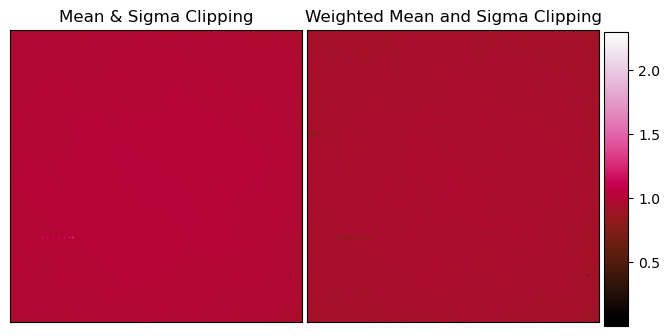

In [135]:
fig = plt.figure(figsize=(6,6))

p1 = fig.add_subplot(1,2,1)
plt.imshow(vf_avg3s, origin='lower', cmap=cmr.flamingo)
plt.xticks(ticks=[])
plt.yticks(ticks=[])
plt.clim(0.0002, 2.3)
plt.title('Mean & Sigma Clipping')

p2 = fig.add_subplot(1,2,2)
p2_ = plt.imshow(vf_weighted_mean, origin='lower',  cmap=cmr.flamingo)
plt.xticks(ticks=[])
plt.yticks(ticks=[])
plt.clim(0.0002, 2.3)
plt.title('Weighted Mean and Sigma Clipping')


c_ax = fig.add_axes([1,0.25,.04,.49])
cb = fig.colorbar(p2_,  cax=c_ax)

plt.tight_layout(pad=0.4)

## 2) Combine Flat Frames (all filters)

In [38]:
flat_names = ['a005otz.fits', 'a006otz.fits', 'a007otz.fits', 'a008otz.fits', 'a009otz.fits']

In [39]:
def get_flat_name(b,a, lst):
    for j in range(b-a):
        c = a+j+1
        name = 'a0'+str(c)+'otz.fits'
        lst.append(name)
    return lst


For some reason, the function above would not actually append the file name to the list given so I had to append the file names manually :(

In [40]:
for i in range(11):
    c = 9+i+1
    name = 'a0'+str(c)+'otz.fits'
    flat_names.append(name)

In [41]:
for i in range(7):
    c = 1+i+21
    name  = 'a0'+str(c)+'otz.fits'
    flat_names.append(name)

In [42]:
for i in range(55-31):
    c = 1+i+31
    name  = 'a0'+str(c)+'otz.fits'
    flat_names.append(name)

In [43]:
for i in range(62-56):
    c = 1+i+56
    name  = 'a0'+str(c)+'otz.fits'
    flat_names.append(name)

In [44]:
flat_names

['a005otz.fits',
 'a006otz.fits',
 'a007otz.fits',
 'a008otz.fits',
 'a009otz.fits',
 'a010otz.fits',
 'a011otz.fits',
 'a012otz.fits',
 'a013otz.fits',
 'a014otz.fits',
 'a015otz.fits',
 'a016otz.fits',
 'a017otz.fits',
 'a018otz.fits',
 'a019otz.fits',
 'a020otz.fits',
 'a022otz.fits',
 'a023otz.fits',
 'a024otz.fits',
 'a025otz.fits',
 'a026otz.fits',
 'a027otz.fits',
 'a028otz.fits',
 'a032otz.fits',
 'a033otz.fits',
 'a034otz.fits',
 'a035otz.fits',
 'a036otz.fits',
 'a037otz.fits',
 'a038otz.fits',
 'a039otz.fits',
 'a040otz.fits',
 'a041otz.fits',
 'a042otz.fits',
 'a043otz.fits',
 'a044otz.fits',
 'a045otz.fits',
 'a046otz.fits',
 'a047otz.fits',
 'a048otz.fits',
 'a049otz.fits',
 'a050otz.fits',
 'a051otz.fits',
 'a052otz.fits',
 'a053otz.fits',
 'a054otz.fits',
 'a055otz.fits',
 'a057otz.fits',
 'a058otz.fits',
 'a059otz.fits',
 'a060otz.fits',
 'a061otz.fits',
 'a062otz.fits']

In [45]:
np.shape(flat_names)

(53,)

In [46]:
flats = ImageFileCollection(location=reduced_dir, 
                             filenames=flat_names)

In [47]:
flat_avg = np.zeros(53)

for i in range(53):
    frame = fits.open(reduced_dir+flat_names[i])
    frame_avg = np.mean(frame[0].data)
    flat_avg[i] = frame_avg

In [49]:
# Each frame will be divided by its average value prior to combining
# inv_avg is the array that will be passed on to the 'scale' variable in ccdp.combine()
inv_avg = 1/flat_avg

In [50]:
master_flat = ccdp.combine(flats.ccds(ccd_kwargs={'unit':'adu'}), method='average', scale=inv_avg,
sigma_clip=True, sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std, unit=u.adu)

master_flat.meta['combined']=True
master_flat.write(reduced_dir+'master_flat.fits', overwrite=True)

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


**Ok I gave in and decided to do the weighted mean & sigma clipping method**

In [136]:
master_flat2 = ccdp.combine(flats.ccds(ccd_kwargs={'unit':'adu'}), method='average', scale=inv_avg,
sigma_clip=True, sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std, unit=u.adu, 
weights=flat_avg)

master_flat2.meta['combined']=True
master_flat2.write(reduced_dir+'master_flat2.fits', overwrite=True)

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


In [137]:
flat1 = fits.open(reduced_dir+'master_flat.fits') # OG flat
flat2 = fits.open(reduced_dir+'master_flat2.fits') # Weighted mean and sigma clipping flat

In [138]:
f1rms = rms(np.array(flat1[0].data))
f2rms = rms(np.array(flat2[0].data))

In [139]:
print('Mean & Sigma Clipping RMS = ', f1rms)
print('Weighted Mean & Sigma Clipping RMS = ', f2rms)

Mean & Sigma Clipping RMS =  1.0003133344836432
Weighted Mean & Sigma Clipping RMS =  1.0002419817785893


## 3) Normalize Master Flat

In [58]:
mf_open = fits.open(reduced_dir+'master_flat.fits')

In [80]:
mf_open[0].data.mean()

1.0000000000000002

**This is already normalized to 1 since the mean pixel value is 1. Therefore, no further normalizing is needed.**

In [142]:
mf_open2 = fits.open(reduced_dir+'master_flat2.fits')

In [143]:
mf_open2[0].data.mean()

0.999847148942626

In [144]:
mf_open2[0].data = mf_open2[0].data/mf_open2[0].data.mean()
mf_open.writeto(reduced_dir+'master_bias2_norm.fits')

**Check:**

In [145]:
norm_open = fits.open(reduced_dir+'master_bias2_norm.fits')

In [146]:
norm_open[0].data.mean()

1.0000000000000002

**Nice.**

## Divide Science Frames by Normalized Master Flat

In [73]:
sci_list = []

In [81]:
for i in range(12):
    c = 1+i+80
    sname = 'a0'+str(c)+'otz.fits'
    sci_list.append(sname)

In [82]:
for i in range(10):
    c = 1+i+129
    sname = 'a'+str(c)+'otz.fits'
    sci_list.append(sname)

In [83]:
for i in range(11):
    c = 1+i+152
    sname = 'a'+str(c)+'otz.fits'
    sci_list.append(sname)

In [84]:
for i in range(10):
    c = 1+i+201
    sname = 'a'+str(c)+'otz.fits'
    sci_list.append(sname)

In [85]:
for i in range(10):
    c = 1+i+236
    sname = 'a'+str(c)+'otz.fits'
    sci_list.append(sname)

In [104]:
# Regular mean and sigma clipping method

for i in range(len(sci_list)):
    sci_ = fits.open(reduced_dir+sci_list[i])
    sci_[0].data = sci_[0].data/mf_open[0].data
    new = sci_list[i].strip('.fits')+'f.fits'
    sci_.writeto(reduced_dir+new, overwrite=True)
    sci_.close()

In [148]:
# Weighted mean and sigma clipping method

for i in range(len(sci_list)):
    sci_2 = fits.open(reduced_dir+sci_list[i])
    sci_2[0].data = sci_2[0].data/norm_open[0].data
    new2 = sci_list[i].strip('.fits')+'f2.fits'
    sci_2.writeto(reduced_dir+new2, overwrite=True)
    sci_2.close()

## 5) Compute Gain and Read Noise for This CCD Using a Few Flats and Bias Images

### Divide Flat Frames by Master Flat

#### Regular mean and sigma clipping

In [105]:
for i in range(len(flat_names)):
    fl = fits.open(reduced_dir+flat_names[i])
    fl[0].data = fl[0].data/mf_open[0].data
    new_fl = flat_names[i].strip('.fits')+'f.fits'
    fl.writeto(reduced_dir+new_fl, overwrite=True)
    fl.close()

#### Weighted Mean and Sigma Clipping

In [149]:
for i in range(len(flat_names)):
    fl2 = fits.open(reduced_dir+flat_names[i])
    fl2[0].data = fl2[0].data/norm_open[0].data
    new_fl2 = flat_names[i].strip('.fits')+'f2.fits'
    fl2.writeto(reduced_dir+new_fl2, overwrite=True)
    fl2.close()

**Why we shouldn't use entire frames to calculate gain and read noise:**
- "Small effects caused by amplifier heating can even
occur between the readout of the beginning and end of a single CCD row, as
the last charge packets pass through a slightly hotter circuit." (Howley 4.3 pg. 46)

- The **signal vs. photons** relationship stops being linear when the detected number of photons are too high. Given that Gain = slope of this linear relationship, oversaturated areas where the relationship is no longer linear will give an innaccurate gain measure

**Therefore, I will use a section of my flat and bias frames that is narrow enough to avoid varying read noise levels due to amplifier heating and homogeneous to avoid an incorrect gain calculation.**

#### Mean and Sigma Clipping Flat Fielding

In [114]:
# Flats
F1 = fits.open(reduced_dir+'a046otzf.fits')
F1 = F1[0].data

F2 = fits.open(reduced_dir+'a047otzf.fits')
F2 = F2[0].data


# Biases
B1 = fits.open(bias_dir+'a098otz.fits')
B1 = B1[0].data

B2 = fits.open(bias_dir+'a099otz.fits')
B2 = B2[0].data

In [117]:
F1_avg = np.mean(F1[993:1236,1153:1525])
F2_avg = np.mean(F2[993:1236,1153:1525])
f1_f2 = F1[993:1236,1153:1525] - F2[993:1236,1153:1525]
f1f2_std = np.std(f1_f2)

B1_avg = np.mean(B1[993:1236,1153:1525])
B2_avg = np.mean(B2[993:1236,1153:1525])
b1_b2 = B1[993:1236,1153:1525] - B2[993:1236,1153:1525]
b1b2_std = np.std(b1_b2)

In [118]:
G = ((F1_avg+F2_avg)-(B1_avg+B2_avg))/(f1f2_std**2-b1b2_std**2)
print('Gain = ', G)

Gain =  1.6195928027322584


In [119]:
rn = (G*b1b2_std)/np.sqrt(2)
print('Read Noise = ', rn)

Read Noise =  13.71215975520769


#### Weighted Mean and Sigma Clipping Flat Fielding

In [159]:
# Flats
F1_ = fits.open(reduced_dir+'a046otzf2.fits')
F1_ = F1_[0].data

F2_ = fits.open(reduced_dir+'a047otzf2.fits')
F2_ = F2_[0].data


# Biases
B1_ = fits.open(bias_dir+'a098otz.fits')
B1_ = B1_[0].data

B2_ = fits.open(bias_dir+'a099otz.fits')
B2_ = B2_[0].data

In [164]:
F1_avg_ = np.mean(F1_[993:1236,1153:1525])
F2_avg_ = np.mean(F2_[993:1236,1153:1525])
f1_f2_ = F1_[993:1236,1153:1525] - F2_[993:1236,1153:1525]
f1f2_std_ = np.std(f1_f2_)

B1_avg_ = np.mean(B1_[993:1236,1153:1525])
B2_avg_ = np.mean(B2_[993:1236,1153:1525])
b1_b2_ = B1_[993:1236,1153:1525] - B2_[993:1236,1153:1525]
b1b2_std_ = np.std(b1_b2_)

In [165]:
G = ((F1_avg_+F2_avg_)-(B1_avg_+B2_avg_))/(f1f2_std_**2-b1b2_std_**2)
print('Gain = ', G)

Gain =  1.6195928027322584


In [166]:
rn = (G*b1b2_std_)/np.sqrt(2)
print('Read Noise = ', rn)

Read Noise =  13.71215975520769
